### 1. Градиентный спуск

В данном разделе предстоит минимизировать функцию $$ f(x, y) = x^2 + y^2 $$ при помощи метода градиентного спуска

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings

warnings.filterwarnings(action='ignore')

Задание 1. Реализуйте функцию gradient_vector таким образом, чтобы она возвращала градиент заданной функции f(x, y)

должен возвращаться numpy array, содержащий 2 numpy array (производные по x и y)

In [2]:
def gradient_vector(x: np.array, y: np.array) -> np.array:
    return np.array([2*x, 2*y])

Задание 2. Реализуйте обновление координат найденного экстремума методом градиентного спуска.

In [3]:
def gradient_descent(vector, lr=0.001, epsilon=0.001, stop_iteration=10000):
    """

    Args:
        vector (np.array): исходные занчения аргументво x, y
        lr (float, optional): learning rate. Коэффициент скорости обучения.
        epsilon (float, optional): Допустимая погрешность
        stop_iteration (int, optional): количество итераций

    Returns:
        np.array, содержащий координаты экстремума, номер итерации, градиенты x, y, значения отклонений от истинного значения
    """
    iteration = 1

    x_gradient = np.array([])
    y_gradient =  np.array([])
    loss =  np.array([])

    extremum = vector - lr * gradient_vector(vector[0], vector[1])
    x_gradient = np.append(x_gradient, extremum[0])
    y_gradient = np.append(y_gradient, extremum[1])

    while np.linalg.norm(np.subtract(extremum[0], extremum[1])) > epsilon:
        loss = np.append(loss, np.absolute(vector[0]-extremum[0]))
        vector = extremum

        extremum = vector - lr * gradient_vector(vector[0], vector[1]) 
        x_gradient = np.append(x_gradient, extremum[0])
        y_gradient = np.append(y_gradient, extremum[1])

        iteration = iteration + 1
        if iteration == stop_iteration:
            break

    return np.array([extremum, iteration, x_gradient, y_gradient, loss])

In [4]:
def plot_contour(x_gradient, y_gradient, vector):
    """
    Визуализация поиска точки экстремума
    """
    figure, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')

    contour = plt.contour(X, Y, Z, cmap=cm.RdBu)
    plt.clabel(contour, fontsize=10)

    ax.text(x=vector[0]+0.05, y=vector[1]-0.25, s='start', c='r')
    plt.plot(vector[0], vector[1], 'ro')

    ax.text(x=x_gradient[-1]+0.05, y=y_gradient[-1]-0.25, s='finish', c='b')
    plt.plot(x_gradient, y_gradient, 'bo')

    plt.show()

In [5]:
def plot_loss(loss):
    figure, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')

    ax = sns.lineplot(data=loss)
    ax.set(xlabel='Iteration')
    ax.set(ylabel='Value')
    ax.set_title('Losses')

    plt.show()

Инициализация функции для поиска точки экстремума, генерация значений функции.

$$   f(x, y) = x^2 + y^2 $$

In [6]:
def f(x, y):
    return np.power(x, 2) + np.power(y, 2)

x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

3. Воспользуйтесь полученной функцией

In [7]:
vector = np.array([2., -2.])
extremum, iteration, gdx_gradient, gdy_gradient, loss = gradient_descent(vector)

Визуализация градиентного спуска

Function extremum reached at point: (0.00050, -0.00050).
Number of iterations: 4143.


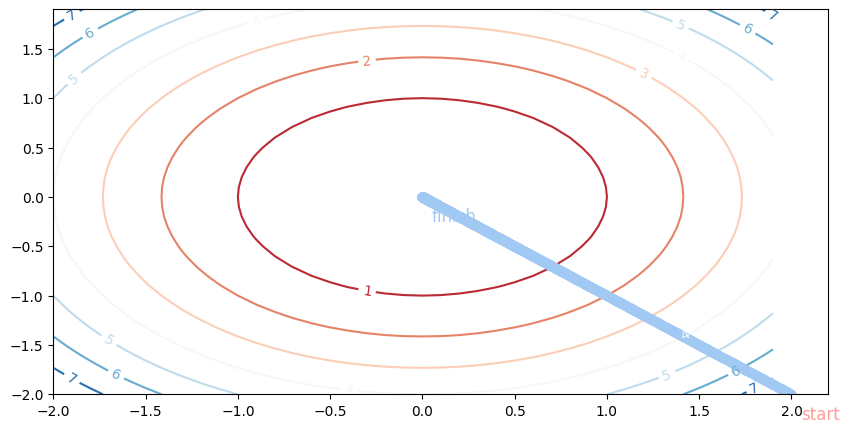

In [8]:
print('Function extremum reached at point: ({:.5f}, {:.5f}).'.format(extremum[0], extremum[1]))
print('Number of iterations: {}.'.format(iteration))

plot_contour(gdx_gradient, gdy_gradient, vector)

Визуализация функции потерь

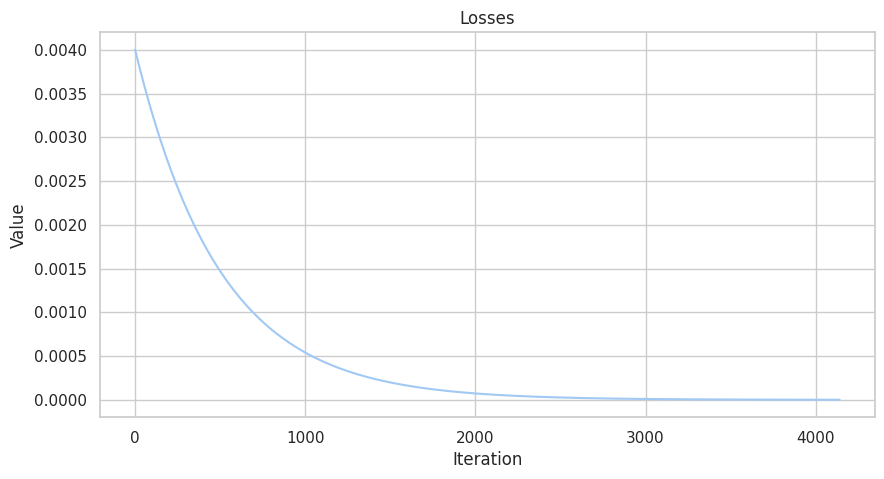

In [9]:
plot_loss(loss)

### 2. Реализация нейронной сети для решения задачи классификации

In [10]:
!wget  -O 'WineQT.csv' -q 'https://www.dropbox.com/scl/fi/qsacgxfmrio4d8crvksad/WineQT.csv?rlkey=o8mb42t8mfru5o9llgu98cxn6&dl=0'

In [11]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_csv('WineQT.csv')

**Колонки**

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- **quality (Target)** : score between 0 and 10
- Id

In [13]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


Разделение на обучающую и тестовую выборки

In [14]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

X_train = df_train.drop(['quality', 'Id'], axis=1)
X_val = df_val.drop(['quality', 'Id'], axis=1)

y_train = df_train['quality']
y_val = df_val['quality']

Задание 4. Примените RabustScaler для стандартизации X_train, X_val

In [15]:
scaler = RobustScaler() 
X_train = scaler.fit_transform(X_train) 
X_val = scaler.transform(X_val)

Преобразование значений к тензорам, для дальнейшей работы с pyTorch

In [16]:
X_train_ts = torch.FloatTensor(X_train)
X_val_ts = torch.FloatTensor(X_val)

y_train_ts = torch.LongTensor(y_train.values)
y_val_ts = torch.LongTensor(y_val.values)

In [17]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(X_train_ts.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 11)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)

        output = self.fc4(x)
        return output

In [18]:
model = DNN()

loss_fn = nn.CrossEntropyLoss()

Задание 5. Заполните пропуски функции train_model

1) Инициализируйте оптимизатор ADAM.

2) Воспользуйтесь методом zero_grad

3) Вычислите градиенты функции потерь по параметрам модели, используя метод обратного распространения ошибки. backward

4) Обновите значения оптимизатора. step

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR


def train_model(model, lr=1e-3, n_epoch=500):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = ExponentialLR(optimizer, gamma=0.1)

    train_losses = []
    val_losses = []

    train_scores = []
    val_scores = []

    for epoch in range(1, n_epoch+1):
        model.train()
        out = model(X_train_ts)
        loss = loss_fn(out, y_train_ts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (torch.argmax(out, dim=1) == y_train_ts).float().mean().item()

        model.eval()
        with torch.no_grad():
            out_val = model(X_val_ts)
            loss_val = loss_fn(out_val, y_val_ts)
            acc_val = (torch.argmax(out_val, dim=1) == y_val_ts).float().mean().item()

            train_losses.append(loss.item())
            val_losses.append(loss_val.item())

            train_scores.append(acc)
            val_scores.append(acc_val)

        if epoch % 20 == 0:
            print('Epoch : {:3d} / {}, Loss : {:.4f}, Accuracy : {:.2f} %, Val Loss : {:.4f}, Val Accuracy : {:.2f} %'.format(
                epoch, n_epoch, loss.item(), acc*100, loss_val.item(), acc_val*100))

    plt.plot(train_scores)
    plt.plot(val_scores)
    plt.legend(["train","test"])
    return train_losses, val_losses, train_losses, val_scores

Epoch :  20 / 700, Loss : 1.6924, Accuracy : 40.15 %, Val Loss : 1.6872, Val Accuracy : 41.48 %
Epoch :  40 / 700, Loss : 1.2480, Accuracy : 55.36 %, Val Loss : 1.2423, Val Accuracy : 63.32 %
Epoch :  60 / 700, Loss : 1.0644, Accuracy : 59.19 %, Val Loss : 1.0590, Val Accuracy : 62.45 %
Epoch :  80 / 700, Loss : 0.9744, Accuracy : 61.16 %, Val Loss : 0.9807, Val Accuracy : 60.70 %
Epoch : 100 / 700, Loss : 0.9220, Accuracy : 63.35 %, Val Loss : 0.9458, Val Accuracy : 60.26 %
Epoch : 120 / 700, Loss : 0.8802, Accuracy : 65.10 %, Val Loss : 0.9247, Val Accuracy : 61.14 %
Epoch : 140 / 700, Loss : 0.8453, Accuracy : 66.85 %, Val Loss : 0.9177, Val Accuracy : 61.57 %
Epoch : 160 / 700, Loss : 0.8111, Accuracy : 68.60 %, Val Loss : 0.9142, Val Accuracy : 60.70 %
Epoch : 180 / 700, Loss : 0.7745, Accuracy : 69.80 %, Val Loss : 0.9205, Val Accuracy : 60.26 %
Epoch : 200 / 700, Loss : 0.7339, Accuracy : 71.23 %, Val Loss : 0.9258, Val Accuracy : 59.83 %
Epoch : 220 / 700, Loss : 0.6860, Accura

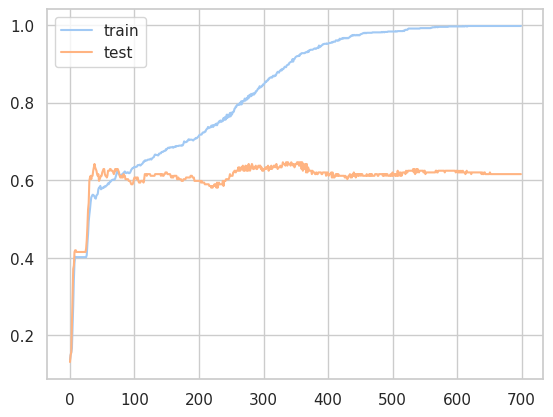

In [20]:
train_model(model, n_epoch=700);

Можно наблюдать переобучение, так как при росте точности на обучающей выборке, на валидационной ее значение начало снижаться

**Комментарий**: переобучение наблюдается примерно на 80 эпохе

Задание 6. Проверьте различные конфигурации (число слоев, их размер) модели DNN.

Можете также опробовать различное число эпох и значения learning_rate при обучении.

Требуется найти такую конфигурацию, при которой переобучения не будет

In [23]:
class BetterDNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
                nn.Linear(X_train_ts.shape[1], 64),
                # nn.BatchNorm1d(128),
                nn.ReLU(),
                # nn.Linear(128, 64),
                # # nn.BatchNorm1d(64),
                # nn.ReLU(),
                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Linear(32, 11)
        )

    def forward(self, x):
        return self.layers(x)

Epoch :  20 / 700, Loss : 2.4147, Accuracy : 2.30 %, Val Loss : 2.4116, Val Accuracy : 2.18 %
Epoch :  40 / 700, Loss : 2.3841, Accuracy : 6.46 %, Val Loss : 2.3824, Val Accuracy : 7.42 %
Epoch :  60 / 700, Loss : 2.3507, Accuracy : 14.77 %, Val Loss : 2.3503, Val Accuracy : 14.85 %
Epoch :  80 / 700, Loss : 2.3132, Accuracy : 22.98 %, Val Loss : 2.3138, Val Accuracy : 22.71 %
Epoch : 100 / 700, Loss : 2.2697, Accuracy : 27.57 %, Val Loss : 2.2717, Val Accuracy : 27.95 %
Epoch : 120 / 700, Loss : 2.2192, Accuracy : 30.85 %, Val Loss : 2.2229, Val Accuracy : 35.81 %
Epoch : 140 / 700, Loss : 2.1614, Accuracy : 37.09 %, Val Loss : 2.1672, Val Accuracy : 39.30 %
Epoch : 160 / 700, Loss : 2.0973, Accuracy : 42.23 %, Val Loss : 2.1044, Val Accuracy : 43.67 %
Epoch : 180 / 700, Loss : 2.0282, Accuracy : 48.80 %, Val Loss : 2.0368, Val Accuracy : 50.22 %
Epoch : 200 / 700, Loss : 1.9559, Accuracy : 51.42 %, Val Loss : 1.9655, Val Accuracy : 52.40 %
Epoch : 220 / 700, Loss : 1.8827, Accuracy :

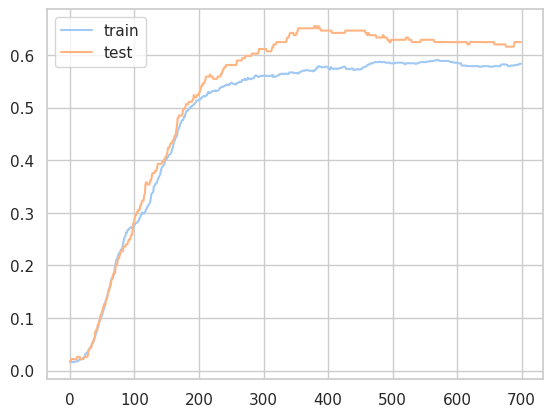

In [24]:
better_model = BetterDNN()

train_model(better_model, lr=1e-4, n_epoch=700)
pass

Часто переобучение вызвано слишком большой сложностью модели. Поэтому упростил модель: уменьшил число слоев до трех, на первом слое уменьшил число нейронов до 64. Также увеличил learning rate.

**Результат:** избавились от переобучения, сохранив при этом качество модели.